Updated analysis incorporating advise from coauthors.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal
from scipy import optimize
from lmfit import Model

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [20]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

In [21]:
#hard coding paths to sectors
s15fits = 'tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
s16fits = 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits'


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


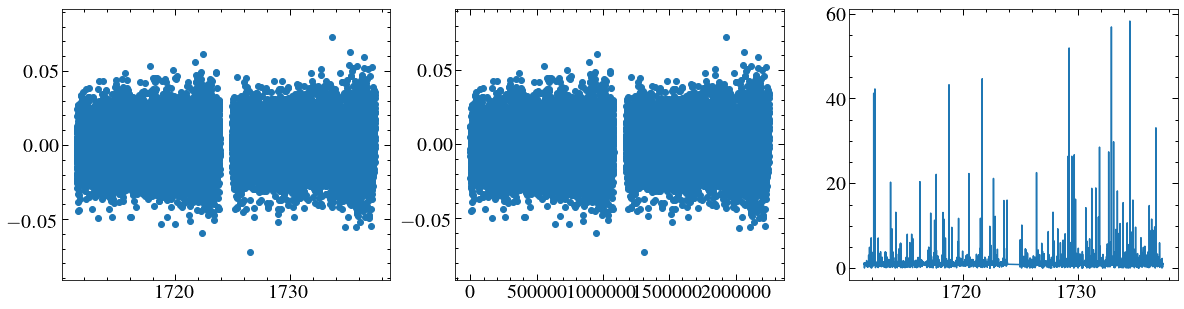

In [22]:
hdul = fits.open(tessfits[0])
data = hdul[1].data
plt.figure(figsize=(20, 5))

plt.subplot(131)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
crowdsap = hdul[1].header['CROWDSAP']
#f /= crowdsap
t, f, e = t[q==0], f[q==0], e[q==0]
fit = np.polyval((np.polyfit(t,f,2)), t)
f = (f/fit)-1
#f -= fit
e = (e/fit)-1
plt.scatter(t,f)
#plt.xlim(t[0], t[100])

plt.subplot(132)
jjt, jjf, jje = np.loadtxt('GD394.go.lc1', unpack=True)
plt.scatter(jjt, jjf)
#plt.xlim(jjt[0], jjt[100])

plt.subplot(133)
plt.plot(t, abs(f)/abs(jjf))
plt.show()
#hdul.close()

Differences are probably in the fit? Or the other thing JJ mentioned?  

Let's look at the background.

In [23]:
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


0.9977675262794609 d


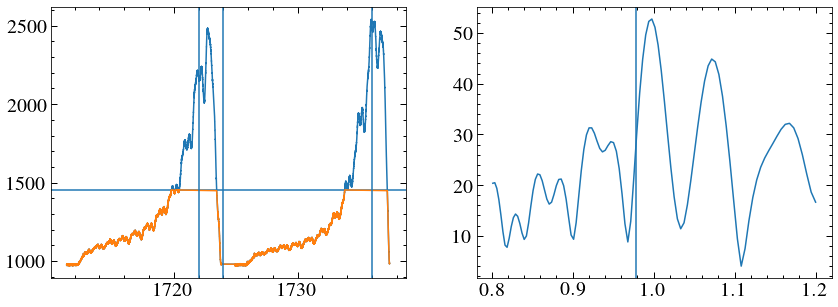

1.1827382285254915 d


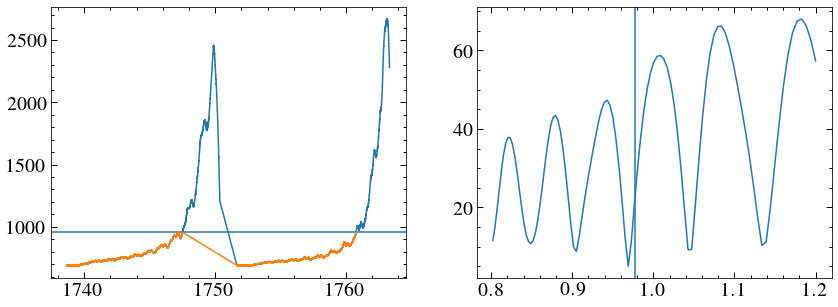

In [24]:
cut_times = [1722, 1724, 1736]#times where bg > 1.1*median bg
for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    lc = lk.LightCurve(time=data['TIME'], flux= data['SAP_BKG'])
    lc = lc.remove_nans()
    plt.plot(lc.time, lc.flux)
    #plt.axhline(np.median(lc.flux), c='g')
    #plt.axhline(1.1*np.median(lc.flux), c='r')
    #tind = np.where(lc.flux > 1.25*np.median(lc.flux))[0][0]
    #plt.axvline(lc.time[tind])
    cut = 1.25*np.median(lc.flux)
    plt.axhline(cut)
    mask =  (data['SAP_BKG'] <= cut)
    plt.plot(data['TIME'][mask], data['SAP_BKG'][mask])
    if i == 0:
        [plt.axvline(line) for line in cut_times]
   # plt.plot(data['TIME'], data['SAP_BKG'])
    
    plt.subplot(122)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.8*u.day, maximum_period=1.2*u.day)
    plt.plot(pg.period, pg.power)
    #pg.plot()
    plt.axvline(0.9776875854871951)
    #plt.show()
    print(pg.period_at_max_power)
    plt.show()

How do the LS look using JJ lcs?

Parameter('fwhm', value=0.06244715052068569, unit=d)
Parameter('x_0', value=1.1441470739927595, unit=d) 0.0014258111721683385
Parameter('x_0', value=0.977554558325995, unit=d) 0.0014098896045141647
Parameter('fwhm', value=0.05223721912356787, unit=d)
Parameter('x_0', value=1.1543654820386422, unit=d) 0.0017686171286158264


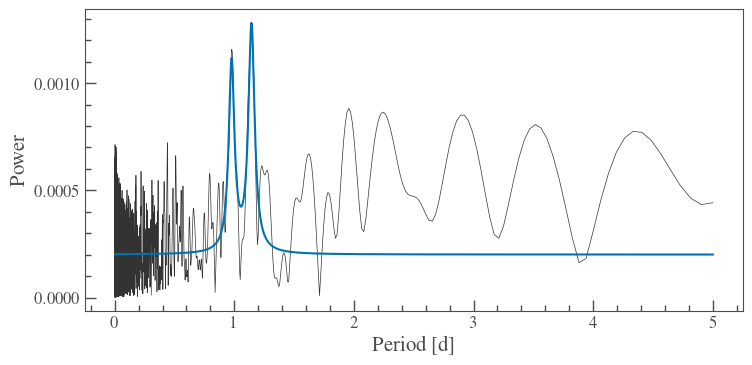

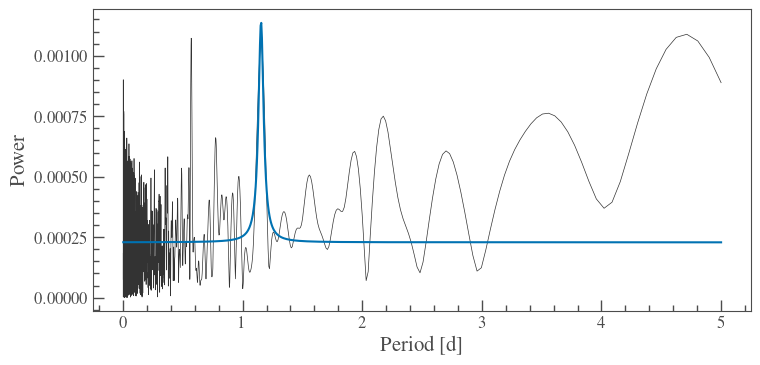

In [25]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lc
    else:
        lc16= lc
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
    pg.plot()
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
    if i == 0:
        l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(l_fit[0].fwhm)
    print(l_fit[0].x_0, fit_e[1])
    if i == 0:
        print(l_fit[2].x_0, fit_e[5])
        pg_noflat = pg
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))

And with background-cut lightcurves?

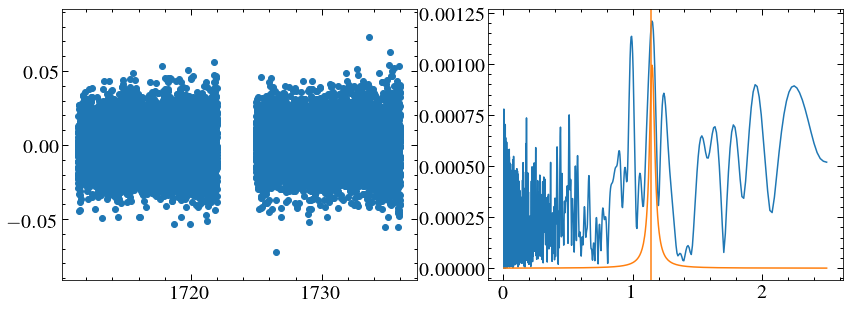

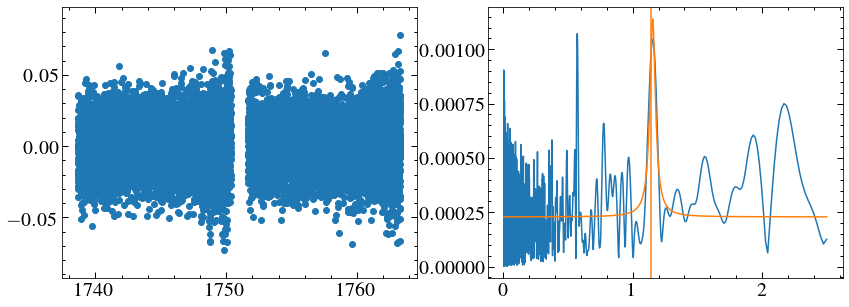

In [26]:

for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
    t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    #cut_mask = (bk < 1.1*np.median(bk))
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )#.remove_outliers(sigma=5)
    if i == 0:
        cut_mask = (t < cut_times[0]) | (t > cut_times[1]) & (t < cut_times[2])
        lc1 = lk.LightCurve(time=t[cut_mask], flux=f[cut_mask], flux_err=e[cut_mask] )
    else:
        lc1=lc
    #lcb = lk.LightCurve(time=t, flux=bk)
    plt.scatter(lc1.time, lc1.flux)
    #plt.scatter(lc1.time, lc1.flux_err)

    
   

 #   if i == 0:
  #      lc15 = lc
  #  else:
   #     lc16= lc
    
    plt.subplot(122)
    pg = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    #pg.plot()
    plt.plot(pg.period, pg.power)
    plt.axvline(1.14, c='C1')
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
  #  if i == 0:
   #     l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print(l_fit[0].fwhm)
    #print(l_fit[0].x_0, fit_e[1])
   # if i == 0:
    #    print(l_fit[2].x_0, fit_e[5])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))
    plt.show()


Don't think that worked very well. Let's go with the uncut lcs for now. Maybe make a plot to send to the TESS GO office.

In [27]:
"""
plt.figure(figsize=(18,6))
max_p = 3
min_p = 0.01
ys=[0.00001, 0.00145]
xs=[0.001, 2.99]

plt.subplot(121)
pg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.xlabel('Period (d)')
plt.ylabel('Power')
plt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.plot(pg15.period, pg15.power)
#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')
#plt.legend()


plt.subplot(122)
pg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.plot(pg16.period, pg16.power)
plt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')
plt.xlabel('Period (d)')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.tight_layout()
plt.savefig('plots/djwilson_query_odd_period.pdf')
"""

"\nplt.figure(figsize=(18,6))\nmax_p = 3\nmin_p = 0.01\nys=[0.00001, 0.00145]\nxs=[0.001, 2.99]\n\nplt.subplot(121)\npg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\n#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.xlabel('Period (d)')\nplt.ylabel('Power')\nplt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.plot(pg15.period, pg15.power)\n#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')\n#plt.legend()\n\n\nplt.subplot(122)\npg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.plot(pg16.period, pg16.power)\nplt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')\nplt.xlabel('Period (d)')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.tight_layout()\nplt.savefig('plots/djwilson_query_odd_peri

Getting rid of the 0.98 d signal.

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude            frequency            phase       
    ---------------------- ------------------ ------------------
    -0.0011613152859176216 1.0207879324072944 3.0576743709083924
0.9796354054085742
[1.61570139e-04 2.85909526e-03 4.93035804e+00]


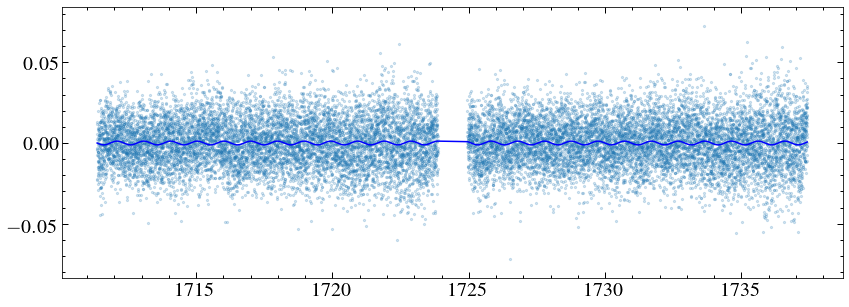

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude            frequency            phase       
    ---------------------- ------------------ ------------------
    -0.0011613152859176216 1.0207879324072944 3.0576743709083924


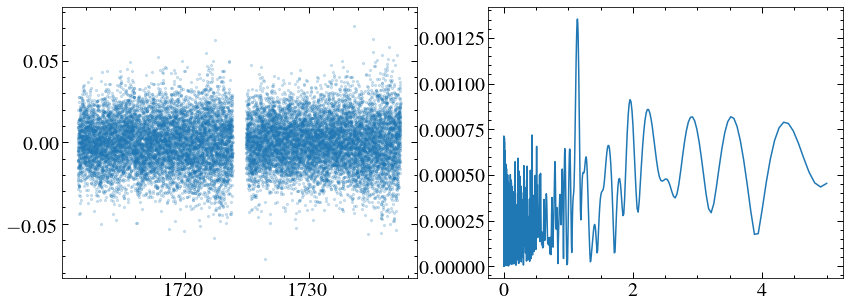

In [28]:
f_earth = 0.978
fitter = fitting.LevMarLSQFitter()
#lc_fold = lc15.fold(0.9776875854871951)#.bin(300)
#lc_fold.scatter()
#sin_mod =  models.Sine1D(amplitude=1, frequency=1, fixed={'frequency':1})#+models.Const1D(1.0, fixed={'amplitude':1.0})
#sin_fit = fitter(sin_mod, lc_fold.time, lc_fold.flux,  weights=1/lc_fold.flux_err, maxiter=100000)
#print(sin_fit)
#plt.plot(lc_fold.time, sin_fit(lc_fold.time), c='r')
#plt.show()
                                                          
#lc_bin = lc15.bin(90)
#lc_bin.scatter()
bg_mod =  models.Sine1D(amplitude=0.001, frequency=1/f_earth)#, bounds={'frequency':[1/(f_earth-e_earth), 1/(f_earth+e_earth)]})#+models.Const1D(1.0, fixed={'amplitude':1.0})
bg_fit = fitter(bg_mod, lc15.time, lc15.flux, maxiter=1000000)
print(bg_fit)
bg_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#plt.plot(lc_bin.time, sin_fit(lc_bin.time), c='r')
#plt.scatter(lc15.time, lc15.flux)
plt.scatter(lc15.time, lc15.flux, s=5, rasterized=True, alpha=0.2) 
plt.plot(lc15.time, bg_fit(lc15.time), c='b') 
print(1/bg_fit.frequency)
print(bg_fit_e)
plt.show()


crowd = fits.getheader(s15fits,1)['CROWDSAP']
#bg_fit.amplitude = bg_fit.amplitude/crowd
print(bg_fit)

lc15_flat = lk.LightCurve(time=lc15.time, flux=lc15.flux-bg_fit(lc15.time), flux_err=lc15.flux_err)
plt.subplot(121)
plt.scatter(lc15_flat.time, lc15_flat.flux, s=5, rasterized=True, alpha=0.2) 
plt.subplot(122)
pg = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
plt.plot(pg.period, pg.power)

#lc15.fold(1/bg_fit.frequency).bin(20).scatter()

Adjusting the fit for CROWDSAP over-subtracts the signal - hint that it's background?

Doing both lcs separately

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase       
    -------------------- ------------------ ------------------
    0.001356314820821409 0.8762030749036531 1.8246660534986703
Period = 1.141287937285497 0.003164761612111856
Amplitude = 0.001356314820821409 0.00016113693454848182
Adjusted Amplitide 0.002454177108952347 0.00029156842504761524
Phase = 1.8246660534986703 4.18979859242052
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase       
    -------------------- ------------------ ------------------
    0.001046654886023885 0.8658056443638982 19.942223351524063
Period = 1.1549936253126343 0.005013708286819811
Amplitude = 0.001046654886023885 0.00018214901670338306
Adjusted Amplitide 0.0017668851895364169 0.0003074904672011291
Phase = 19.942223351524063 6.581036708415894


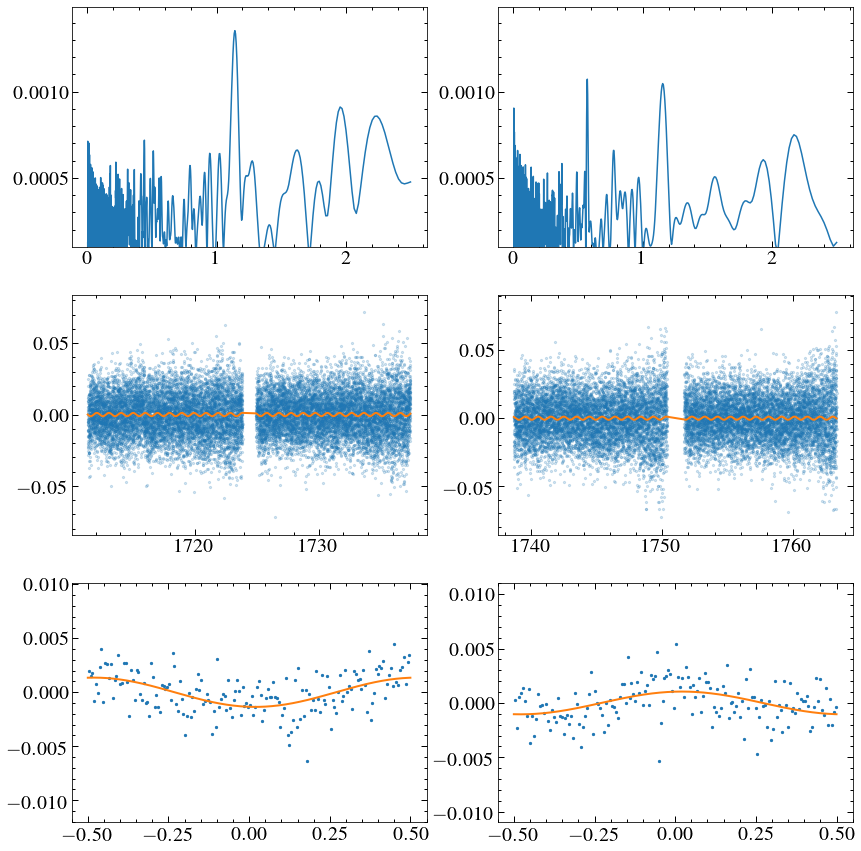

In [29]:
plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.0001, 0.00149)
    
    plt.subplot(3,2,i+3)
    sin_mod =  models.Sine1D(amplitude=0.001, frequency=1/1.14)
    sin_fit = fitter(sin_mod, lc.time, lc.flux)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, bg_fit(lc.time), c='C1', lw=2) 
    
    pbin =100
    plt.subplot(3,2,i+5)
    #if i == 0:
    t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=5)
    
    fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2)
    
    
    print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
    print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2])
    

In [30]:
#Period = 1.141287937285497 0.003164761612111856
#Adjusted Amplitide 0.002454177108952347 0.00029156842504761524
#Period = 1.1549936253126343 0.005013708286819811
#Adjusted Amplitide 0.0017668851895364169 0.0003074904672011291
p15, p15e = 1.14, 0.003
a15, a15e= 0.0025, 0.0003
p16, p16e = 1.155, 0.005
a16, a16e= 0.0018, 0.0003


What about the combined lc?

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude           frequency            phase      
    --------------------- ------------------ -----------------
    0.0011811472588348268 0.8726166875144319 8.022351975106165
Period = 1.1459785428220581 0.001400307681752864
Amplitude = 0.0011811472588348268 0.0001210640507211929
Adjusted Amplitide 0.0019939252433291248 0.00020437135588901258
Phase = 8.022351975106165 1.8524445877922757


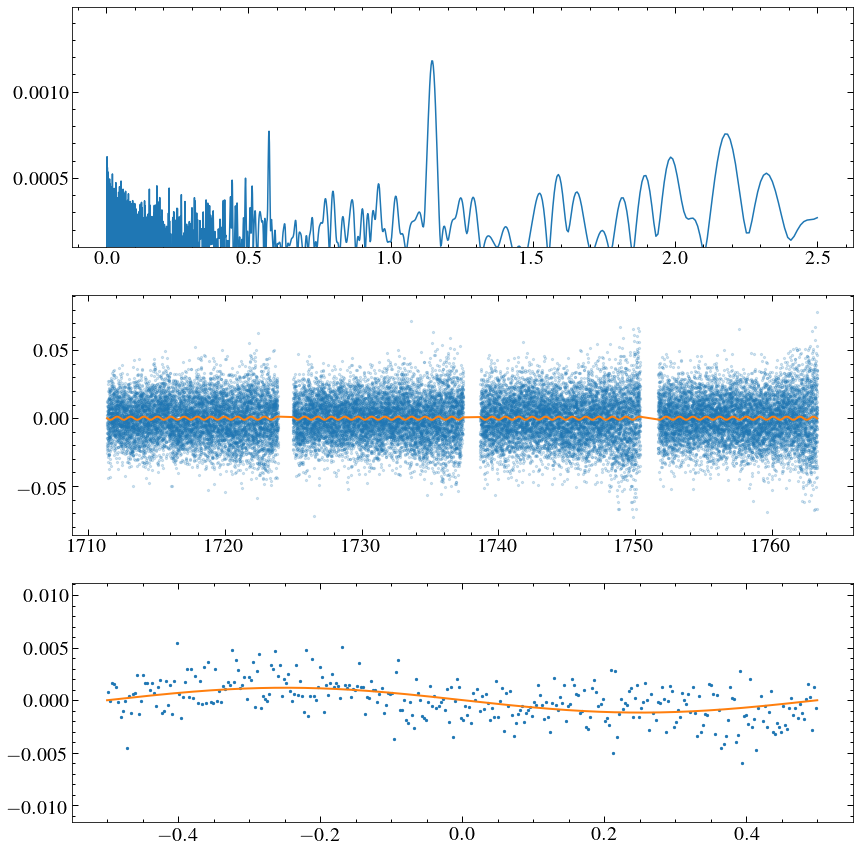

In [31]:
lc2s = lc15_flat.append(lc16)
lc = lc2s

plt.figure(figsize=(14, 15))
plt.subplot(311)
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
plt.plot(pg.period, pg.power)
plt.ylim(0.0001, 0.00149)

plt.subplot(312)
sin_mod =  models.Sine1D(amplitude=0.001, frequency=1/1.14)
sin_fit = fitter(sin_mod, lc.time, lc.flux)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
plt.plot(lc.time, bg_fit(lc.time), c='C1', lw=2) 

pbin =100
plt.subplot(313)
#if i == 0:
t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to


lc_fold = lc.fold(1/sin_fit.frequency, t0 = t0)#.bin(50)
#plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
#  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=5)

fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2)


print(sin_fit)
print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])

crowd = fits.getheader(tessfits[i],1)['CROWDSAP']

print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
print('Phase =', sin_fit.phase.value, sin_fit_e[2])

False alarm proabilites

In [32]:
#arr = np.array(lc.flux)
#arr2 = np.random.shuffle(arr)

In [33]:
"""n = 10000
peak_collections = []
check = np.arange(500, n+1, 500)

for lc in [lc15_flat, lc16]:
    #lc = lc.remove_nans()
    i = 0
    max_peak = []
    while i < n:
        i+=1
        arr = np.array(lc.flux)
        np.random.shuffle(arr)
        fake_lc = lk.LightCurve(time=lc.time, flux=arr)
        fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
        max_peak.append(max(fake_pg.power).value)
        if i in check:
            print(i)
    peak_collections.append(max_peak)
"""

'n = 10000\npeak_collections = []\ncheck = np.arange(500, n+1, 500)\n\nfor lc in [lc15_flat, lc16]:\n    #lc = lc.remove_nans()\n    i = 0\n    max_peak = []\n    while i < n:\n        i+=1\n        arr = np.array(lc.flux)\n        np.random.shuffle(arr)\n        fake_lc = lk.LightCurve(time=lc.time, flux=arr)\n        fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n        max_peak.append(max(fake_pg.power).value)\n        if i in check:\n            print(i)\n    peak_collections.append(max_peak)\n'

In [34]:
#np.save('fake_peaks2', np.array(peak_collections))

In [35]:
peak_collections = np.load('fake_peaks2.npy')
for s in peak_collections:
    fa99 = np.percentile(s, 99)
    print(fa99)

0.0008921727340759394
0.0010066298849730551


Period = 1.141706774302507 0.003101907949609799
Amplitude = -0.0013765324977870357 0.00015973301425161916
Adjusted Amplitide -0.002490759884015724 0.00028902810844673395
Adjusted Amplitide (folded) -0.0024541964934426176 0.0002915819424727053
Phase = -11.11587778573777 4.1028739139290185 0.23085310359444167 -0.08520795162955493
Period = 1.1547228801714955 0.005080700929241081
Amplitude = -0.0010222339787934165 0.00017927092037305203
Adjusted Amplitide -0.0017256596242839818 0.0003026318783309817
Adjusted Amplitide (folded) -0.0017667155978780763 0.0003074566907160669
Phase = 6.089058018669871 6.671174319469804 0.9691036824446523 1.0617503691713304


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


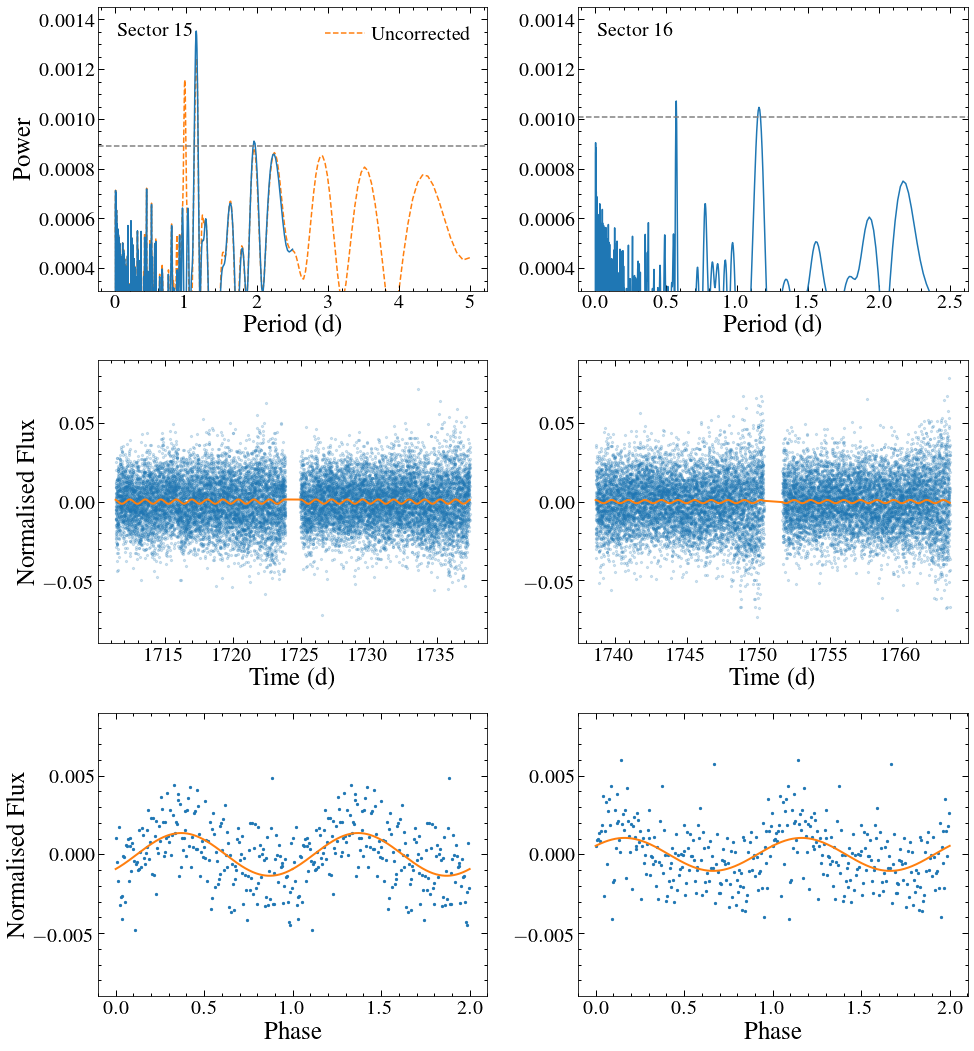

In [36]:
periods = []
period_errors = []
amplitudes = []
amplitude_errors = []

orb_split = [1724.5, 1751 ] #tae to get the pericenters
sectors = [15, 16]
plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.00031, 0.00145)
    plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')
    if i == 0:
        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Power', size=25)
        plt.legend()
    plt.xlabel('Period (d)', size=25)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    
    
    
    plt.subplot(3,2,i+3)
    sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Time (d)', size=25)
    plt.ylim(-0.09, 0.09)
    #plt.axvline(orb_split[i])
    
    
    
    pbin =90
    plt.subplot(3,2,i+5)
    #if i == 0:
    #t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency)#, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    
    fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
    plt.plot(lc_fold.time+0.5,fold_fit(lc_fold.time), c='C1', lw=2)
    plt.plot(lc_fold.time+1.5,fold_fit(lc_fold.time), c='C1', lw=2)
    
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Phase', size=25)
    plt.ylim(-0.009, 0.009)

    
  #  print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
    print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Adjusted Amplitide (folded)', fold_fit.amplitude.value/crowd, fold_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
    
    periods.append(1/sin_fit.frequency.value)
    period_errors.append(sin_fit_e[1]/(sin_fit.frequency.value**2))
    amplitudes.append(sin_fit.amplitude.value/crowd)
    amplitude_errors.append(sin_fit_e[0]/crowd)
plt.tight_layout()
#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)

In [37]:
print(periods)
print(period_errors)
print(amplitudes)
print(amplitude_errors)

[1.141706774302507, 1.1547228801714955]
[0.003101907949609799, 0.005080700929241081]
[-0.002490759884015724, -0.0017256596242839818]
[0.00028902810844673395, 0.0003026318783309817]


2.561872082270474
2.528154878961459


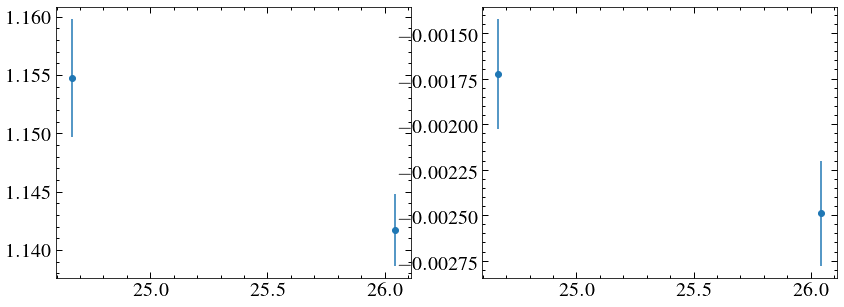

In [38]:
mid_times = [lc15_flat.time[-1] -lc15_flat.time[0], lc16.time[-1] -lc16.time[0]]
plt.subplot(121)
plt.errorbar(mid_times, periods, yerr=period_errors, marker='o', ls='none')
plt.subplot(122)
plt.errorbar(mid_times, amplitudes, yerr=amplitude_errors, marker='o', ls='none')
print(abs((periods[0]-periods[1])/max(period_errors)))
print(abs((amplitudes[0]-amplitudes[1])/max(amplitude_errors)))

In [39]:
def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

print(new_coadd(np.array(periods),np.array(period_errors)))
print(new_coadd(abs(np.array(amplitudes)),np.array(amplitude_errors)))

(1.1452410636171362, 0.0057889103405861075)
(0.0021257920625978957, 0.0003821458678175557)


In [40]:
fits.getheader(s15fits,1)

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18757 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [41]:
lc15.time[0]

1711.3675622914366

In [42]:
min(lc15.time)

1711.3675622914366

Testing with limfit, scipy- both don't work well

In [43]:
"""def test_func(x, a, b, c):
    return a * np.sin(b * x +c)




sectors = [15, 16]
plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.00031, 0.00145)
    plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')
    if i == 0:
        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Power', size=25)
        plt.legend()
    plt.xlabel('Period (d)', size=25)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    
    
    
    plt.subplot(3,2,i+3)
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    #sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    #sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    #sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
   # params, params_covariance = optimize.curve_fit(test_func, lc.time,lc.flux,)
    #print(params)
    smodel = Model(test_func)
    result = smodel.fit(lc.flux, x=lc.time, a=0.01, b=1/1.15, c=0)
    print(result.fit_report())
    plt.plot(lc.time, result.best_fit, 'r-', label='best fit')
    #plt.plot(lc.time, test_func(lc.time, params[0], params[1]), c='C1')
    
    
   
  #  plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Time (d)', size=25)
    plt.ylim(-0.09, 0.09)
    
    
    pbin =90
    plt.subplot(3,2,i+5)
    #if i == 0:
    #t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency)#, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    
    #fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    #fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
   # fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
   # plt.plot(lc_fold.time+0.5,fold_fit(lc_fold.time), c='C1', lw=2)
    #plt.plot(lc_fold.time+1.5,fold_fit(lc_fold.time), c='C1', lw=2)
    
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Phase', size=25)
    plt.ylim(-0.009, 0.009)

    
  #  print(sin_fit)
 #   print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
  #  print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
   # crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
   # print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
   # print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
plt.tight_layout()
#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)"""

"def test_func(x, a, b, c):\n    return a * np.sin(b * x +c)\n\n\n\n\nsectors = [15, 16]\nplt.figure(figsize=(14, 15))\nfor i, lc in enumerate([lc15_flat, lc16]):\n    plt.subplot(3,2, i+1)\n    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    plt.plot(pg.period, pg.power)\n    plt.ylim(0.00031, 0.00145)\n    plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')\n    if i == 0:\n        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')\n        plt.ylabel('Power', size=25)\n        plt.legend()\n    plt.xlabel('Period (d)', size=25)\n    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )\n    \n    \n    \n    plt.subplot(3,2,i+3)\n    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) \n    #sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})\n    #sin_fit = fitter(sin_mod, lc.time, lc.flux, weigh

What if we treat each orbit separatly?

In [44]:
lco1 = lk.LightCurve(time = lc15_flat.time[(lc15_flat.time < orb_split[0])], flux = lc15_flat.flux[(lc15_flat.time < orb_split[0])], flux_err=lc15_flat.flux_err[(lc15_flat.time < orb_split[0])])
lco2 = lk.LightCurve(time = lc15_flat.time[(lc15_flat.time > orb_split[0])], flux = lc15_flat.flux[(lc15_flat.time > orb_split[0])], flux_err=lc15_flat.flux_err[(lc15_flat.time > orb_split[0])])
lco3 = lk.LightCurve(time = lc16.time[(lc16.time < orb_split[1])], flux = lc16.flux[(lc16.time < orb_split[1])], flux_err=lc16.flux_err[(lc16.time < orb_split[1])])
lco4 = lk.LightCurve(time = lc16.time[(lc16.time > orb_split[1])], flux = lc16.flux[(lc16.time > orb_split[1])], flux_err=lc16.flux_err[(lc16.time > orb_split[1])])

Period = 1.2155792312854437 0.018253964602456287
Amplitude = 0.0008324889315347699 0.00022345254696263674
Phase = 80.770740599307 21.21509830004381 0.8550626235729464 0.22458921977433316
Period = 1.1407751617641817 0.005987090705414852
Amplitude = -0.002183625391619976 0.00022568840785680994
Phase = -12.347726720584753 7.963453894303555 0.034798256471058275 -0.02244253677459907
Period = 1.164454127046825 0.012655843921449582
Amplitude = -0.001326017739419782 0.0002555481882298724
Phase = 18.71542101026653 16.279179998476764 0.9786517658298322 0.851257807293328
Period = 1.1752246017313273 0.02231061831332135
Amplitude = -0.0007598790859890693 0.00025115377768067794
Phase = 32.651531373635464 28.38707360592007 0.19665261763418762 0.17096877532935717


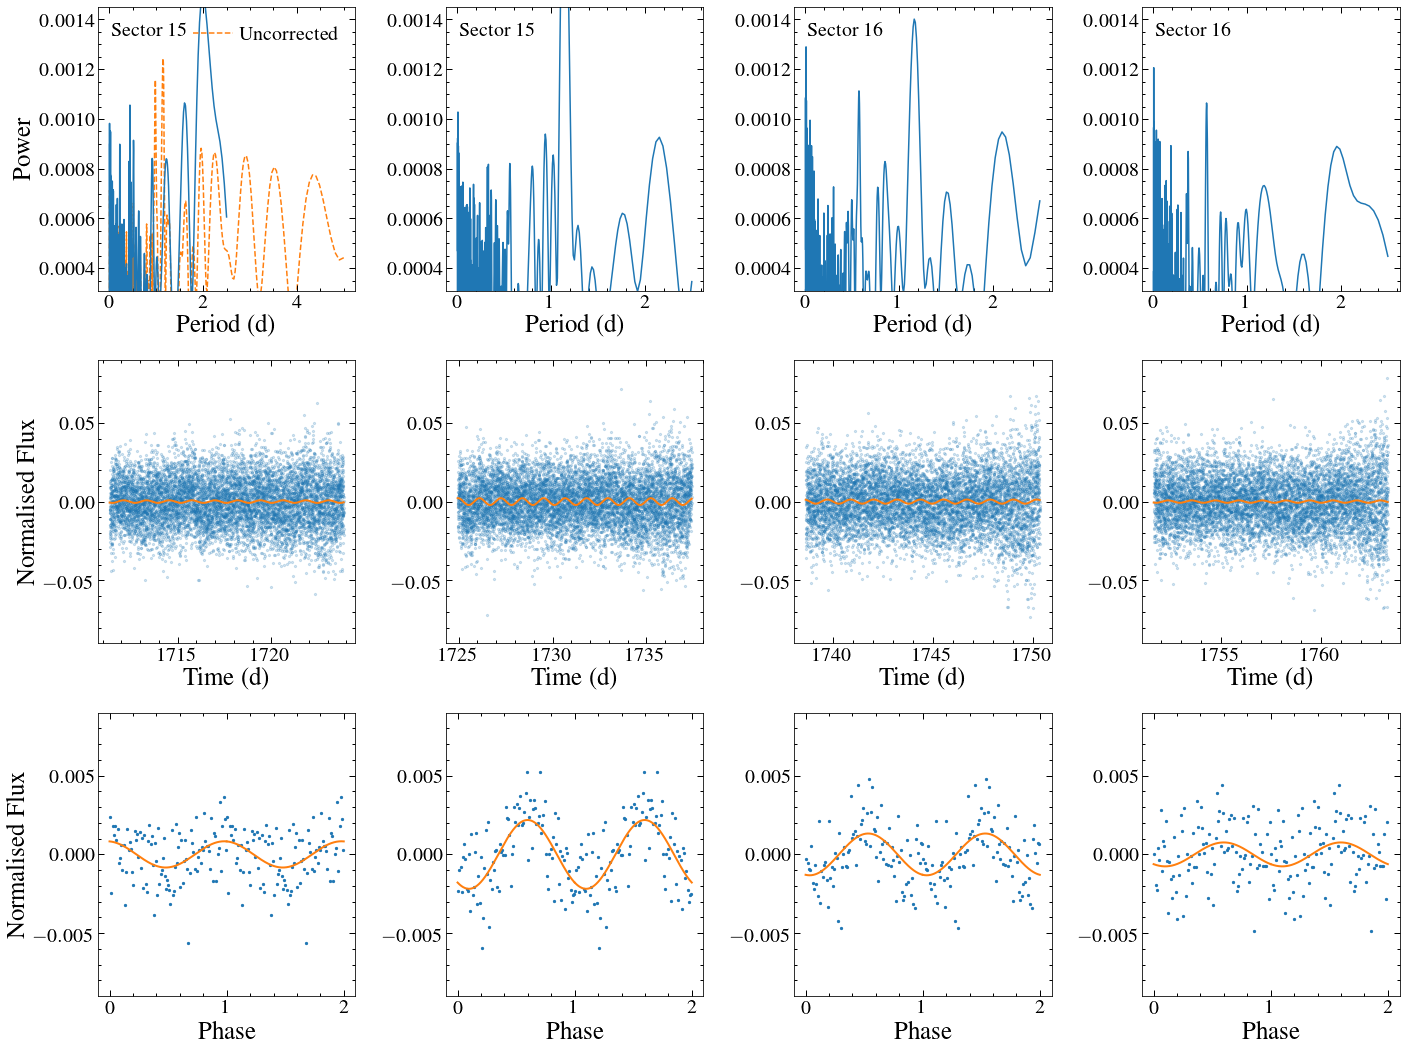

In [45]:
#orb_split = [1724.5, 1751 ] #tae to get the pericenters
sectors = [15, 15, 16, 16]
plt.figure(figsize=(20, 15))
for i, lc in enumerate([lco1, lco2, lco3, lco4]):
    plt.subplot(3,4, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.00031, 0.00145)
   # plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')
    if i == 0:
        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Power', size=25)
        plt.legend()
    plt.xlabel('Period (d)', size=25)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    
    
    
    plt.subplot(3,4,i+5)
    sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Time (d)', size=25)
    plt.ylim(-0.09, 0.09)
    #plt.axvline(orb_split[i])
    
    
    
    pbin =90
    plt.subplot(3,4,i+9)
    #if i == 0:
    #t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency)#, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    
    #fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    #fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
    plt.plot(lc_fold.time+0.5,fold_fit(lc_fold.time), c='C1', lw=2)
    plt.plot(lc_fold.time+1.5,fold_fit(lc_fold.time), c='C1', lw=2)
    
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Phase', size=25)
    plt.ylim(-0.009, 0.009)

    
  #  print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    #crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
  #  print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
plt.tight_layout()
#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)

Something to think about later. Otherwise, let's go with the two sectors. 